# This is the notebook for the IBM Data Science Capstone Project

# In this notebook we will be analyzing the various categories of the shop all over Toronto and form clusters thus making it easier to locate the said type of shop

### Let's start off by importing pandas, numpy and the postal code data stored from the wikipedia link

In [1]:
import pandas as pd
import numpy as np
# reading the table from the wikipedia page
x=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

# Well that was easy,

### The wikipedia page consisted of several other tables but we are only concerned with the postal code table so let's extract that

In [2]:
# cities is a pandas dataframe that stores the extracted postal code table
cities=x[0]
# here we change the column name of the dataframe
cities.columns=cities[0][0],cities[1][0],cities[2][0]
cities=cities.iloc[1:,:]
cities.head()#displays the first 5 rows of our data

,Postcode,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


# Time for some cleaning my dudes

### now we perform some cleaning on our data, dropped all the rows where no borough were assigned

In [3]:
#replacing the Not assigned data with numpy.nan
cities['Borough'].replace('Not assigned',np.nan,inplace=True)
#dropping every row with a Nan
cities.dropna(inplace=True,axis=0)
cities.head()

C:\Users\stqc0\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\stqc0\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Postcode,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor


In [4]:
#grouping the data based on postal codes and boroughs to reduce redundant entries
c=cities.groupby(['Postcode','Borough'])['Neighborhood'].apply(','.join).reset_index()
c.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


# Now that it's been taken care of  let's proceed to gathering some geographical data 

### The geospatial data below will provide us with the borough Latitude and Longitude

In [5]:
#gathering the geospatial data from http://cocl.us/Geospatial_data
geo_df=pd.read_csv('http://cocl.us/Geospatial_data')
#changing the column name to Postcode latitude and longitude
geo_df.columns=['Postcode','lattitude','longitutde']
geo_df.head()

,Postcode,lattitude,longitutde
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
#merging the Neighborhood and geospatial data 
c=pd.merge(c,geo_df,on='Postcode')
c.head()

,Postcode,Borough,Neighborhood,lattitude,longitutde
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Let's do some visualization shall we?

### Let's go ahead and import Folium more info at https://python-visualization.github.io/folium/

In [8]:
#lets import folium and plot all the boroughs on the map of Toronto
import folium 
Toronto=folium.Map(location=[43.653963 ,-79.387207], zoom_start=11)
#this loop reads all the data from our Neighbourhood data set and plots all the boroughs on the map of Toronto
for l,l1,nei in zip(c.lattitude,c.longitutde,c.Neighborhood):
    nei = folium.Popup(nei, parse_html=True)
    folium.CircleMarker(
    [l,l1],
    radius=5,
        popup=nei,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(Toronto)
    
Toronto

# Let's gather more data
## Because we need it!

### Time to shine Foursquare API

In [10]:
import requests
client_id='use your own client id'
client_secret='same goes for this folks'
version_='20180605' #this you can copy

In [17]:
#This is the heart of our model and the problem we seek to solve, this fuctions returns us the Json data of all the types of shops in Toronto
def getNearbyShops(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                  
        # create the API request URL
        url=f'https://api.foursquare.com/v2/venues/search?&ll={lat},{lng}&query=shops&client_id={client_id}&client_secret={client_secret}&v={version_}'
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        for i in range(len(results)):
            if results[i]['categories']== []:
                pass
            else:
                venues_list.append([(
                    name, 
                    lat, 
                    lng,    
                    results[i]['categories'][0]['name']) ])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [47]:
#This right here stores the entire dataset extracted with the help of Foursquare API
shops=getNearbyShops(c.Neighborhood,c.lattitude,c.longitutde)

In [48]:
shops.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Automotive Shop
1,"Rouge,Malvern",43.806686,-79.194353,Doctor's Office
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Automotive Shop
3,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Doctor's Office
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Automotive Shop


# Some more cleaning to do.....
(I don't even clean my room this often)
### Let's jump into it!

In [49]:
#here we created a list of all the columns we do not need, (there's a lazier way to do this but I was too lazy to try)
j=['Accessories Store', 'American Restaurant','Burger Joint', 'Business Service',
       'Butcher','Deli / Bodega','Fast Food Restaurant',
       'Fishing Store', 'Food Court','Hot Dog Joint'
    , 'Market','Metro Station', 'Mobile Phone Shop', 'Office', 'Parking','Sports Bar','Building','Bar', 'Boutique','Coffee Shop',
       'Cosmetics Shop', 'Flower Shop', 'General Entertainment','Liquor Store', 'Medical Center','Shoe Store', 'Shopping Mall', 'Sporting Goods Shop', 'Travel Agency','Grocery Store']

for x in j:
    shops.replace(x,np.nan,inplace=True)
    shops.dropna(axis=0,inplace=True)


In [50]:
shops.shape

(297, 4)

In [51]:
#Cleaning continues, now we make numeric values of the column Venue Category of the shop dataframe 
cat_shops=pd.get_dummies(shops['Venue Category'])
#and then we merge the Latitude and longitude value of the dataframe shops to cat_shops along with Neighborhood names
cat_shops=pd.merge(shops[['Neighborhood Latitude','Neighborhood Longitude']],cat_shops, on=shops.Neighborhood)
cat_shops.head()

,key_0,Neighborhood Latitude,Neighborhood Longitude,Automotive Shop,Bank,Clothing Store,Doctor's Office,Furniture / Home Store,Salon / Barbershop,Women's Store
0,"Rouge,Malvern",43.806686,-79.194353,1,0,0,0,0,0,0
1,"Rouge,Malvern",43.806686,-79.194353,0,0,0,1,0,0,0
2,"Rouge,Malvern",43.806686,-79.194353,1,0,0,0,0,0,0
3,"Rouge,Malvern",43.806686,-79.194353,0,0,0,1,0,0,0
4,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,1,0,0,0,0,0,0


# A little break from all that cleaning let's visulaize the populairty of various categories of shops in Toronto
### matplotlib to the rescue

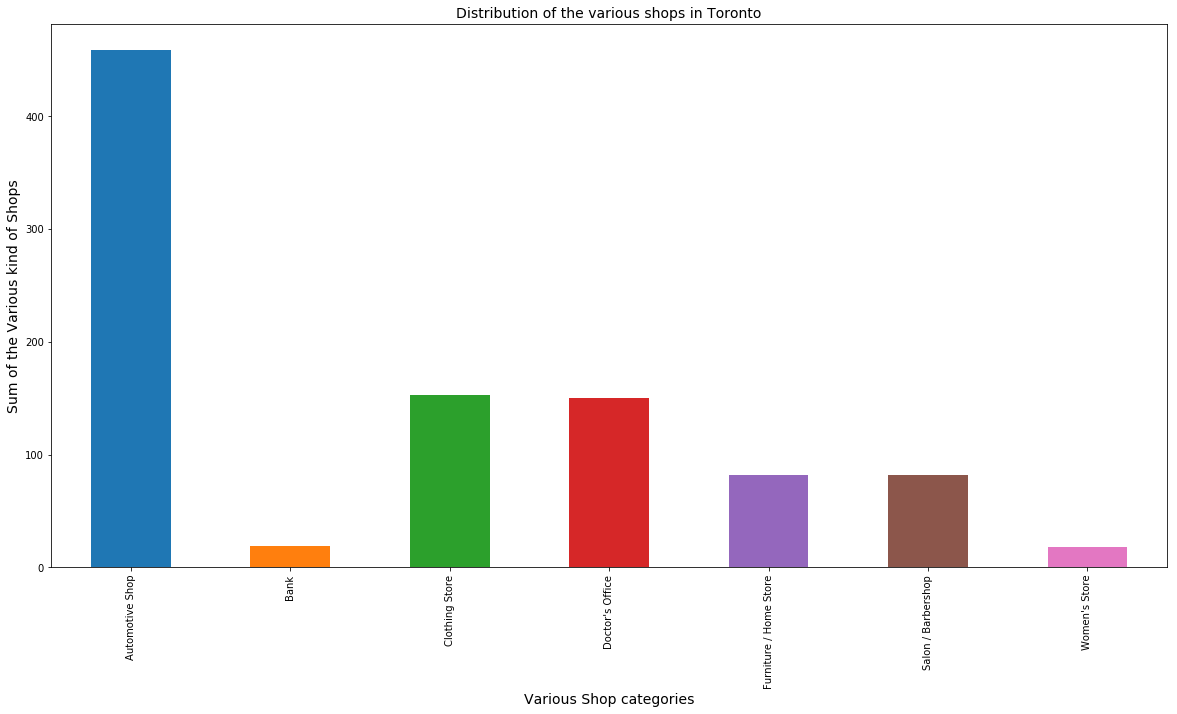

In [63]:
# Let's import matplotlib and visualze our data
import matplotlib.pyplot as plt
%matplotlib inline
#here we plot a bar graph of the sum of the frequncies of each shop category
cat_shops.iloc[:,3:].sum().plot(kind='bar',figsize=(20,10))
#setting the Y label text
plt.ylabel('Sum of the Various kind of Shops',fontsize=14)
#setting the x label text
plt.xlabel('Various Shop categories',fontsize=14)
#setting the title for the graph because why not?
plt.title('Distribution of the various shops in Toronto',fontsize=14)
#finally let's show it(it could be seen without the need to write this but the output won't be too clean and we are all about cleanliness here)
plt.show()

# Interesting results, guess everyone wants to pimp their ride in Toronto

# Let's just perform the final bit of editing on the data

In [68]:
#Now we group the cat_shops datafram by the column key_0 (Neighborhood names) and with the mean of the frequencies of the categories
cat_shops=cat_shops.groupby(cat_shops['key_0']).mean().reset_index()
cat_shops.head()

,key_0,Neighborhood Latitude,Neighborhood Longitude,Automotive Shop,Bank,Clothing Store,Doctor's Office,Furniture / Home Store,Salon / Barbershop,Women's Store,labels
0,"Adelaide,King,Richmond",43.650571,-79.384568,0.333333,0.000000,0.0,0.000000,0.333333,0.333333,0.0,1.666667
1,Agincourt,43.794200,-79.262029,0.500000,0.000000,0.0,0.500000,0.000000,0.000000,0.0,2.000000
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",43.815252,-79.284577,0.333333,0.333333,0.0,0.333333,0.000000,0.000000,0.0,1.333333
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739416,-79.588437,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000
4,"Alderwood,Long Branch",43.602414,-79.543484,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000


# Now is the fun part, let's from the C L U S T E R S
### For this we will use Sci-kit learn and K-Means algorithm
#### More Info on KMeans here : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [69]:
#Importing KMeans from Sklearn.clusters
from sklearn.cluster import KMeans
#creating a KMeans object that will give us 5 clusters from our data
km=KMeans(n_clusters=5)
km.fit(cat_shops.iloc[:,3:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [70]:
#a little more editing the data
shop_1=shops.groupby('Neighborhood')['Venue Category'].apply(','.join).reset_index()
#adding a labels column based on our Kmeans cluster
cat_shops['labels']=km.labels_

# It's visualization time everybody
##### *(ps: the result will shock you)*
just kidding it won't shock anybody

In [72]:
#following the same method as before the difference being the colour of markers for the different clusters
tor_map=folium.Map(location=[43.653963 ,-79.387207],zoom_start=11)
# The marker colour list
colors=['red',
    'blue',
    'gray',
    'orange',
    'green',
    ]

for lat,long,n,category,h in zip(cat_shops['Neighborhood Latitude'],cat_shops['Neighborhood Longitude'],cat_shops.key_0,cat_shops.labels,shop_1['Venue Category']):
    map_label=folium.Popup(f'Locations: {n}\nCluster: {category+1}\nCategories:{h}',parse_html=True)
    folium.CircleMarker(
        [lat,long],
        popup=map_label,
        color=colors[category],
        fill=True,
        fill_opacity=0.7,
        radius=5,
    ).add_to(tor_map)
    

tor_map

# Let's jump into the results

## Cluster number 1 ( Red Marker)
### This Cluster consists of Automotive shops and saloons/barber shops

## Cluster number 2 ( Blue Marker)
### This cluster consists of mostly just Automotive shops

## Cluster number 3 (Gray Marker)
### This cluster consists of again Automotive shops, Doctor's office and Banks

## Cluster number 4 (Orange Marker)
### This cluster consists of yet again Automotive shops , Furniture / Home store and some Saloon/ Barber shop

## Cluster number 5(Green Marker)
### This cluster, once again consists of Automotive shops, Clothing Store and Women's Stores



# Conclusion

### From the results above we can clearly see that Automotive shops are spread all over Toronto while other categories of shops spread uniformly throughout the city.
### In conclusion of this capstone project notebook battle of the neighbourhoods I would like to say that I enjoyed and gained tons of knowledge from this course.